In [1]:
from qiskit import *
from qiskit.circuit.library import *
from qiskit.providers.aer import AerSimulator
method = "statevector"
device = "CPU"
backend = AerSimulator(method=method, device=device)

In [2]:
from qrao import QuantumRandomAccessEncoding, QuantumRandomAccessOptimizer, MagicRounding
from qiskit.utils import QuantumInstance
import networkx as nx
from qiskit_optimization.applications import Maxcut
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import NFT
from qiskit_aer.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE
import matplotlib.pyplot as plt
import multiprocessing

## 1) Input CNF
A 3SAT CNF is of the form $(x_1 \lor x_2 \lor x_3) \land (\neg x_2 \lor x_3 \lor x_4)$ for example

In this notebook, we will assume that the cnf variables ($x_1, x_2, ...$) are given as integers (starting from 0) instead of strings, i.e.
$x_1 \mapsto 0$, $x_2 \mapsto 1$, etc... This is not very intuitive but it makes parsing easier. We might change it later.

- $\neg$ operator: The negation is denoted by an `n` in front of a particular variable $\implies$ Ex: $\neg x_2 \mapsto$ `n3`
- $\lor$ operator: The $\lor$ operator is denoted by a space between operands $\implies$ Ex: $x_1 \lor \neg x_2 \lor x_3 \mapsto$ `0 n1 2` 
- $\land$ operator: The $\land$ operator is denoted by a comma (`,`) between clauses $\implies$ Ex: $(x_1 \lor \neg x_2 \lor x_3) \land (\neg x_1 \lor \neg x_2 \lor \neg x_3) \mapsto$ `0 n1 2,n0 n1 n2`

Therefore, for example, given the following CNF:

$(x_1 \lor x_2 \lor \neg x_3) \land (x_3 \lor \neg x_1 \lor \neg x_6) \land (\neg x_2 \lor x_4 \lor x_5) \land (\neg x_4 \lor \neg x_5 \lor x_6)$

the input CNF to this program will be formulated as

`0 1 n2,2 n0 n5,n1 3 4,n3 n4 5` (as a string)


### Parsing the Input CNF
Given an input CNF, we want to parse is so that
- Instead of having variables `0`, `1`, `2`..., `n0`, `n1`, `n2`, ... we will work with only integers from now on, therefore we will transform the input CNF into a list of integers such that `x` $\mapsto$ `x`, and `nx` $\mapsto$ `x+N` (where `N` is the number of variables)
- Ex: `0 1 n2,2 n0 n5,n1 3 4,n3 n4 5` will be parsed to `parsed_cnf = [0,1,8,2,6,11,7,3,4,9,10,5]`
- We don't need commas or spaces anymore since we know that the input is a 3SAT CNF, so we know the first clause is represented by `(0,1,8)`, the second one by `(2,6,11)`, etc.

The function `parse_cnf()` will ask for two inputs from the user:
- The number of variables (here we count $x$ and $\neg x$ as one variable), so the CNF above has `6` variables.
- The CNF (ex: `0 1 n2,2 n0 n5,n1 3 4,n3 n4 5`)

In [3]:
def parse_cnf():
    """Asks the user to input the number of variables used and the CNF itself, and parses the CNF

    Returns
    -------
    list(int)
        the parsed CNF according to the conventions we decide to use
    """
    num_variables = int(input("Enter the number of variables: "))
    cnf = input("Enter the CNF of the form above (ex: 0 1 2,0 n1 2): ")
    clauses = cnf.replace(",", " ")
    parsed_cnf = clauses.split(" ")
    for i in range(len(parsed_cnf)):
        if parsed_cnf[i].startswith("n"):
            parsed_cnf[i] = str(int(parsed_cnf[i][1:])+num_variables)
    parsed_cnf = list(map(lambda elem: int(elem), parsed_cnf))
    return parsed_cnf, num_variables

In [4]:
# Example: 
# - Number of variables: 6
# - CNF: 0 1 n2,2 n0 n5,n1 3 4,n3 n4 5
parsed_cnf, num_variables = parse_cnf()
print(f"Parsed CNF: {parsed_cnf}")

Parsed CNF: [0, 1, 8, 2, 6, 11, 7, 3, 4, 9, 10, 5]


## 2) Create a graph from the CNF
Let us transform the CNF into a graph $G$, where
- Each clause maps to a triangle
- The weight of an edge $(i,j)$, $W_{ij}$, is set to $M$ if $j = i+N$, otherwise it is set to the number of triangles that share the edge $(i,j)$.

In [5]:
# Create a graph G from an already-parsed CNF
def create_maxcut_graph(parsed_cnf, num_variables, penalty_factor):
    """Creates a weighted graph from a CNF

    Parameters
    ----------
    parsed_cnf : list(int)
        the parsed cnf containing values in [0, 2N-1]
    num_variables : int
        the number of variables used in the CNF (= N)
    penalty_factor: int
        the penalty factor used for assuring consistency

    Returns
    -------
    nx.Graph
        the obtained graph
    """
    
    # All the variables used in the parsed cnf (ranging from 0 to 2N-1)
    cnf_variables = set(parsed_cnf)

    # All the variables used in the original CNF (ranging from 0 to N-1)
    variables = set(range(num_variables))

    # Will contain the weight associated with each edge (i,j)
    edge_weights = {}

    G = nx.Graph()

    # Create the vertices
    vertices = list(cnf_variables)
    G.add_nodes_from(vertices)
    # Iterate over the parsed CNF per clause (3 elements by 3 elements)
    for i in range(0, len(parsed_cnf), 3):

        # First edge
        # If that edge already exists in the map, add 1 to its value
        if (parsed_cnf[i], parsed_cnf[i+1]) in edge_weights:
            edge_weights[(parsed_cnf[i], parsed_cnf[i+1])] = edge_weights[(parsed_cnf[i], parsed_cnf[i+1])] + 1
        else: # Otherwise, set the weight value to 1
            edge_weights[(parsed_cnf[i], parsed_cnf[i+1])] = 1

        # Second edge
        # If that edge already exists in the map, add 1 to its value
        if (parsed_cnf[i], parsed_cnf[i+2]) in edge_weights:
            edge_weights[(parsed_cnf[i], parsed_cnf[i+2])] = edge_weights[(parsed_cnf[i], parsed_cnf[i+2])] + 1
        else: # Otherwise, set the weight value to 1
            edge_weights[(parsed_cnf[i], parsed_cnf[i+2])] = 1

        # Third edge
        # If that edge already exists in the map, add 1 to its value
        if (parsed_cnf[i+1], parsed_cnf[i+2]) in edge_weights:
            edge_weights[(parsed_cnf[i+1], parsed_cnf[i+2])] = edge_weights[(parsed_cnf[i+1], parsed_cnf[i+2])] + 1
        else: # Otherwise, set the weight value to 1
            edge_weights[(parsed_cnf[i+1], parsed_cnf[i+2])] = 1
    
    # Add all the "clause edges" to the graph after calculating all the weights needed
    for (u,v) in edge_weights.keys():
        G.add_edge(u, v, weight=edge_weights[(u,v)], color="b")


    # Add all the "constraint" edges to the graph, with a weight of penalty_factor each
    for var in variables:
        # Check if both x and not(x) exist in the CNF (otherwise we don't need to add the penalty term)
        if var in cnf_variables and var + num_variables in cnf_variables:
            G.add_edge(var, var+num_variables, weight=penalty_factor, color="r")    
    
    return G

### Display The Graph
- The graph contains vertices in $\{0, ..., 2N-1\}$
- Blue edges are clause edges
- Red edges are penalty edges

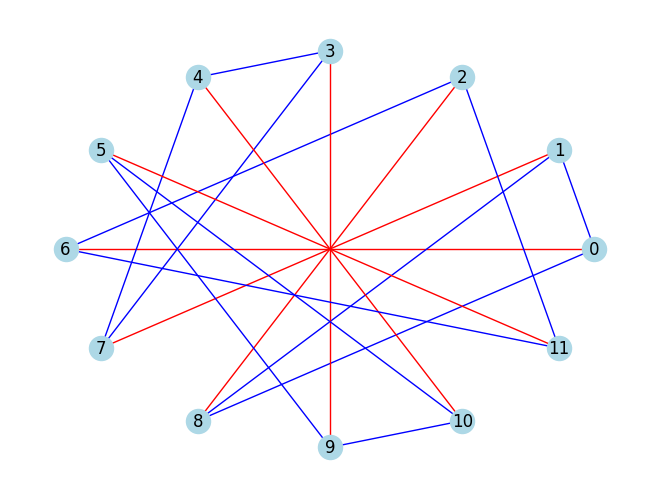

In [6]:
M = 20 # penalty factor to ensure some x_i is not equal to not(x_i)
G = create_maxcut_graph(parsed_cnf, num_variables, M)
edge_colors = [G[u][v]['color'] for u,v in G.edges]
nx.draw_circular(G, with_labels=True, edge_color=edge_colors, node_color="lightblue")

## 3) Theoretical Cut Value

### 3.1) NAE-3SAT Minimization Problem
Given a CNF composed of C clauses and with penalty factor M:
If the values $\{w_1, ..., w_{2N}\}$ satisfy the 3-SAT CNF with the NAE constraint, then (proven):
$\begin{equation}
\min\limits_{w_i}\sum\limits_{j = 1}^{C}(w_1^{(j)}w_2^{(j)} + w_1^{(j)}w_3^{(j)} + w_2^{(j)}w_3^{(j)}) + M\sum\limits_{i\in neg\_var} w_iw_{i+N} = -C-M\lvert \texttt{neg\_var}\rvert
\end{equation}$
where $w_k^{(j)}$ is variable $k$ in clause $j$, and $\texttt{neg\_var}$ is the set of variable indices $i$ such that both $w_i$ and $w_{i+N}$ appear in the parsed CNF. 

The minimization problem can be transformed into the following:
$\begin{equation}
\min\limits_{x \in \{-1,1\}^{|V|}} \left\{\sum\limits_{(i,j) \in E}W_{ij}x_ix_j\right\}
\end{equation}$
where $W_{ij}$ is the weight of edge $(i, j)$ from the previously obtained graph (that weight is equal to the number of triangles that share that edge if
$j \neq i + n$, and $M$ otherwise)

### 3.2) Link Between NAE-3SAT and Weighted Max-Cut
The weighted Max-Cut problem is the following:
$\begin{equation}
        \max\limits_{x \in \{-1,1\}^{|V|}} \left\{\frac{1}{2}\sum\limits_{(i,j) \in E} W_{ij}(1-x_ix_j)\right\} = \max\limits_{x \in \{-1,1\}^{|V|}} \left\{\frac{1}{2}\sum\limits_{(i,j)\in E}W_{ij} - \frac{1}{2}\sum\limits_{(i,j) \in E} W_{ij}x_ix_j\right\}
\end{equation}$
where $x_k \in \{-1, 1\}$
Since we want to maximize this, we would like to minimize the second sum (because of the $-$ sign). However this second sum was computed before and is equal to $-C-M\lvert\texttt{neg\_var}\rvert$ if $x$ satisfies the CNF with the NAE constraint. 

Therefore, if $x$ satisfies the CNF with NAE constraint, then the theoretical Max-Cut value is:
$\begin{equation}
\text{MaxCutValue}_{theory} = \frac{1}{2}\sum\limits_{(i,j)\in E}W_{ij}+\frac{1}{2}(C+M|neg\_var|)
\end{equation}$

In the next cell we compute this value from the original CNF and the (equivalent) graph.

In [7]:
# Get the theoretical Max-Cut value according to the previous formula
def get_theoretical_maxcut_value(G, parsed_cnf, num_variables, M):
    """Compute the theoretical max-cut value
    
    Parameters
    ----------
    G : nx.Graph
        the graph whose max-cut to compute
    parsed_cnf : list(int)
        the parsed cnf containing values in [0, 2N-1]
    num_variables: int
        the number of variables used in the CNF (= N)
    M : int
        the penalty factor for consistency

    Returns
    -------
    float
        the theoretical max-cut value
    """
    # cnf_contribution is the second part of the MaxCutValue_theory above
    cnf_contribution = -len(parsed_cnf)/3 # == -C
    variables = set(range(num_variables))
    for i in variables:
        if i in parsed_cnf and i + num_variables in parsed_cnf:
            cnf_contribution -= M
    # weight_contribution is the first part of the MaxCutValue_theory above
    weight_contribution = G.size(weight="weight")
    return 1/2 * weight_contribution - 1/2 * cnf_contribution

In [8]:
theoretical_maxcut_value = get_theoretical_maxcut_value(G, parsed_cnf, num_variables, M)
print(f"Theoretical Max-Cut value: {theoretical_maxcut_value}")

Theoretical Max-Cut value: 128.0


## 4) Compute the Max-Cut value Experimentally
We can choose to either solve only the relaxed problem (`should_round=False`) or the relaxed + rounding version (`should_round=True`).

In [9]:
def compute_max_cut_qrao(G, rounding_scheme, intermediate_results, should_round=False):
    """Compute the relaxed max-cut (or rounded max-cut if should_round=True) using the protoype-qrao library

    Parameters
    ----------
    G : nx.Graph
        the graph whose max-cut to compute
    rounding_scheme: RoundingScheme
        the rounding technique to use (ignored when should_round=False)
    intermediate_results: list(float)
        the intermediate energy values computed from the eigensolver 
    should_round: bool
        if False, we do not perform rounding, otherwise we perform rounding  

    Returns
    -------
    Either a float (non-rounded, relaxed max-cut value) or a list[int] containing the solution to the 3SAT-NAE problem
    """

    maxcut = Maxcut(G)
    problem = maxcut.to_quadratic_program()
    encoding = QuantumRandomAccessEncoding(3) # Use (3,1)-QRAC
    encoding.encode(problem)
    ansatz = EfficientSU2(encoding.num_qubits, reps=3)
    threads = multiprocessing.cpu_count()

    # results will be either a number (if we solve the relaxed version), or 
    # an array of values in {0,1} (if we perform rounding)
    results = None 
    vqe = VQE(
        Estimator(        
            approximation=True,
            abelian_grouping=False,
            backend_options={"method": method, "device": device, "max_parallel_experiments": threads},
        ),
        ansatz,
        NFT(maxiter=96),
        # for now let's have this callback
        callback= lambda c,p,value,m: intermediate_results.append(problem.objective.sense.value * (encoding.offset + value))
    )
    # Create the qrao instance
    qrao = QuantumRandomAccessOptimizer(encoding=encoding, min_eigen_solver=vqe, rounding_scheme=rounding_scheme)

    if not should_round:
        # We just need to solve the relaxed problem
        eigensolver_result, _ = qrao.solve_relaxed()
        # Relaxed MaxCut Value (computed from the gotten minimimum eigenvalue)
        results = problem.objective.sense.value * (encoding.offset + eigensolver_result.eigenvalue.real)
    else:
        # Otherwise we solve the relaxed problem but also perform rounding at the end
        rounded_results = qrao.solve()
        results = rounded_results.x # variable assignments
    return results

### Compute Rounded and Non-Rounded Results
Let us compute the non-rounded (= relaxed) and the rounded solutions of the Max-Cut problem in the cells below

In [10]:
# Compute relaxed max-cut value

rounding_scheme = MagicRounding(QuantumInstance(backend=backend, shots=1024))
intermediate_results = []
relaxed_maxcut_value = compute_max_cut_qrao(G, rounding_scheme, intermediate_results, should_round=False)
print(f"Relaxed Max-Cut Value: {relaxed_maxcut_value}")

# The relaxed maxcut value should be >= than the theoretical value, so if it is not, then we know the CNF is not NAE-SAT
if relaxed_maxcut_value < theoretical_maxcut_value:
    print("Not NAE-SAT")
# Otherwise we cannot conclude anything, the CNF might be NAE-SAT or not.
else:
    print("Maybe NAE-SAT")

Relaxed Max-Cut Value: 156.79717726479373
Maybe NAE-SAT


### Plot the Intermediate Results (for the case when we don't perform rounding)

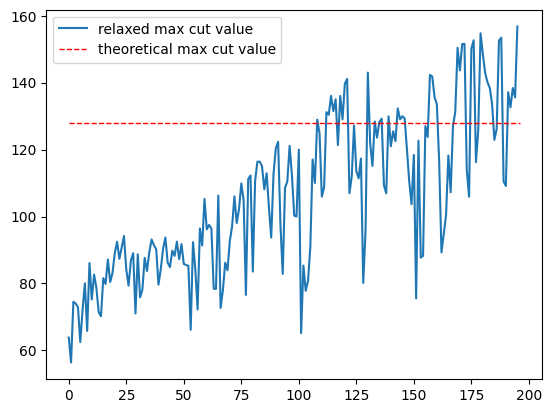

In [11]:
fig, ax = plt.subplots()
ax.plot(intermediate_results, label="relaxed max cut value")
ax.hlines(y=theoretical_maxcut_value, xmin=0, xmax=len(intermediate_results), linewidth=1, linestyles="--", color='r', label="theoretical max cut value")
plt.legend()

### Calculate the exact values for $x$
We can perform rounding to get the values for $x$ and see if they satisfy the CNF

In [12]:
# Compute rounded results
rounding_scheme = MagicRounding(QuantumInstance(backend=backend, shots=1024))
intermediate_results = []
x_values = compute_max_cut_qrao(G, rounding_scheme, intermediate_results, should_round=True)
print("Variable assignments:")

# The first N values are the non-negated variables, and the second N values are the negated ones
print(x_values)

Variable assignments:
[1 0 1 1 0 0 0 1 0 0 1 1]


## 5) Calculate the Error (Only Done After Rounding)
To calculate the error, we will look at the results (`x_values`) which are the values (0 or 1) we assign to the variables, and check two things:
- NAE-SAT errors: If a clause is not NAE-SAT, then we add 1 to the NAE-SAT error
- Consistency errors: If a variable is the same as its negation, we add 1 to the consistency error

In [13]:
def calculate_error(parsed_cnf, num_variables, result):
    """Calculate the NAE
    """
    nae_sat_error = 0
    consistency_error = 0
    # Iterate over the clauses of the CNF
    for i in range(0, len(parsed_cnf), 3):
        v1 = result[parsed_cnf[i]]
        v2 = result[parsed_cnf[i+1]]
        v3 = result[parsed_cnf[i+2]]
        # if clause is satisfied but not SAT-NAE, or if the clause is not satisfied, we add 1 to nae_sat_error
        if v1 + v2 + v3 == 3 or v1 + v2 + v3 == 0:
            nae_sat_error += 1
    
    for i in range(num_variables):
        # if a variable is the same as its negation, we add 1 to consistency_error
        if  i + num_variables < len(result) and result[i] == result[i+num_variables]:
            consistency_error += 1
    return nae_sat_error, consistency_error

In [14]:
nae_sat_error, consistency_error = calculate_error(parsed_cnf, num_variables, x_values)
total_error = nae_sat_error + consistency_error
print(f"Total error = {total_error} (NSE: {nae_sat_error}, CE: {consistency_error})")
if total_error == 0:
    print("Success! The CNF is NAE-SAT")

Total error = 0 (NSE: 0, CE: 0)
Success! The CNF is NAE-SAT
